In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.distributions import uniform, randint
from sklearn.metrics import roc_curve,roc_auc_score

In [5]:
data_raw = pd.read_csv('Data/feature_selection_data.csv')

y = data_raw.pop('y')

data_numerics = data_raw.select_dtypes(include = ['number'])
data_categorical = data_raw.select_dtypes(exclude = ['number'])

categorical_dummies = pd.get_dummies(data_categorical)
numeric_scaler = MinMaxScaler()
numerics_scaled = numeric_scaler.fit_transform(data_numerics)
numerics_scaled = pd.DataFrame(numerics_scaled, columns=data_numerics.columns, index=data_numerics.index)

data_adult = pd.concat([categorical_dummies, numerics_scaled], axis=1)

In [6]:
data_adult.head()

,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,education_10th,education_11th,education_12th,...,native.country_Thailand,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0.134328,0.280419,0.600000,0.0,0.0,0.244898
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0.552239,0.322052,0.533333,0.0,0.0,0.397959
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0.477612,0.258095,0.533333,0.0,0.0,0.397959
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0.059701,0.088938,0.600000,0.0,0.0,0.295918
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0.477612,0.161116,0.866667,0.0,0.0,0.469388


In [7]:
X_train,X_test,y_train,y_test = train_test_split(data_adult,y,test_size = 0.2)

In [8]:
estimator = XGBClassifier(max_depth=5,n_jobs=-1)

xgboost_score = cross_val_score(estimator=estimator,X=X_train,y=y_train,cv=KFold(5,shuffle=True))

In [9]:
xgboost_score

array([ 0.853125,  0.809375,  0.825   ,  0.8375  ,  0.8625  ])

In [10]:
xgboost_score.mean()

0.83750000000000002

In [11]:
estimator.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### wiecej podzialow na zmiennej ciaglej niz kategorycznej dlatego lepiej patrzec na gain, tutaj mozemy wychwycic czy model sie przuczyl na jakiejs zmiennej

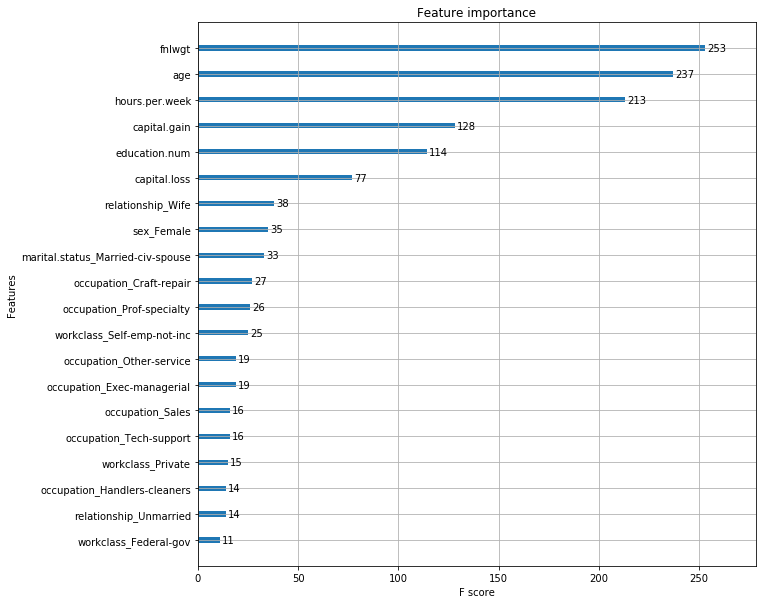

In [13]:
plt.figure(figsize=(10,10))
plot_importance(booster=estimator,max_num_features=20,ax=plt.gca(),importance_type='weight')
plt.show()

### model oparty glownie na jednej zmiennej nie jest dobry

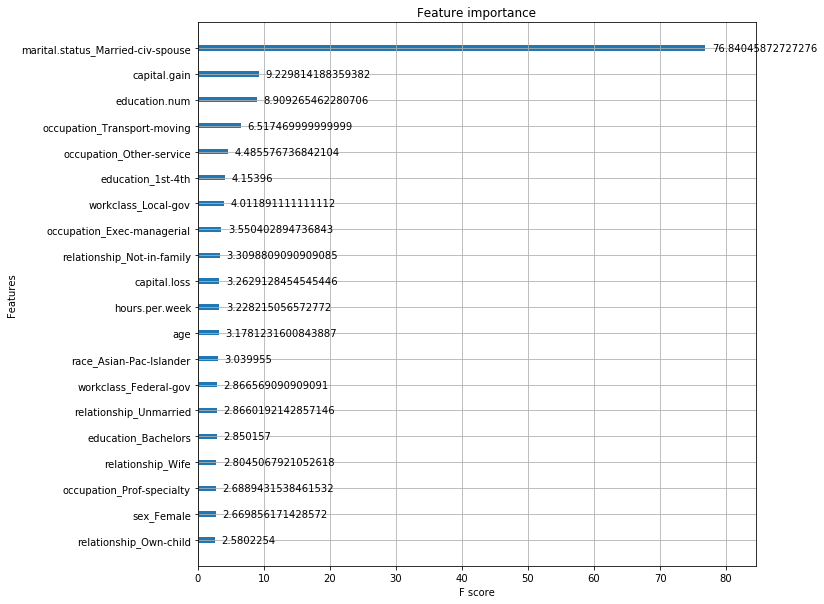

In [14]:
plt.figure(figsize=(10,10))
plot_importance(booster=estimator,max_num_features=20,ax=plt.gca(),importance_type='gain')
plt.show()

### tutaj widac czy ktoras zmienna pokrywa tylko mala czesc danych, wiec nie jest ogolna dla calego modelu

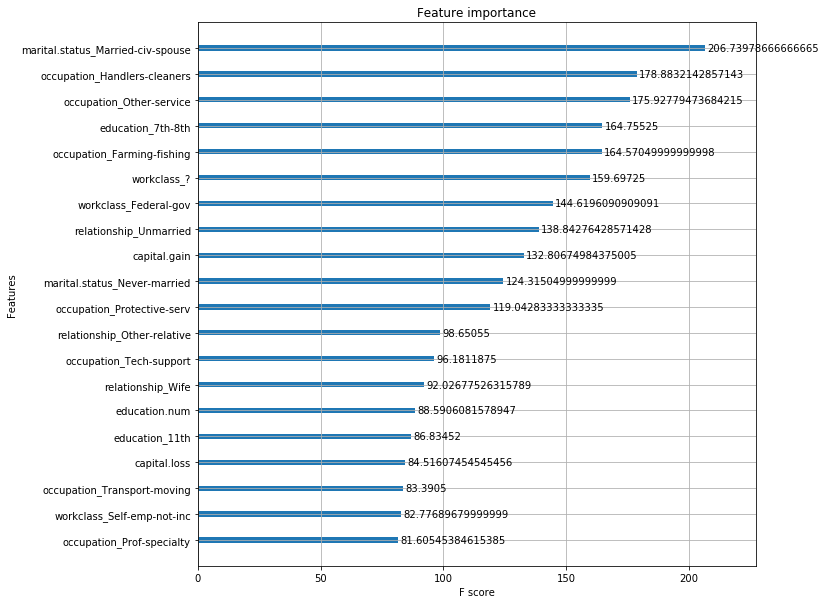

In [15]:
plt.figure(figsize=(10,10))
plot_importance(booster=estimator,max_num_features=20,ax=plt.gca(),importance_type='cover')
plt.show()

In [23]:
estimator = XGBClassifier(max_depth=5,learning_rate=0.1,n_estimators=100,gamma=0.2,n_jobs=-1,reg_alpha=0.3)

xgboost_score = cross_val_score(estimator=estimator,X=X_train,y=y_train,cv=KFold(5,shuffle=True))
print(xgboost_score)
print(xgboost_score.mean())

[ 0.83125   0.865625  0.825     0.80625   0.825   ]
0.830625


In [24]:
estimator.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

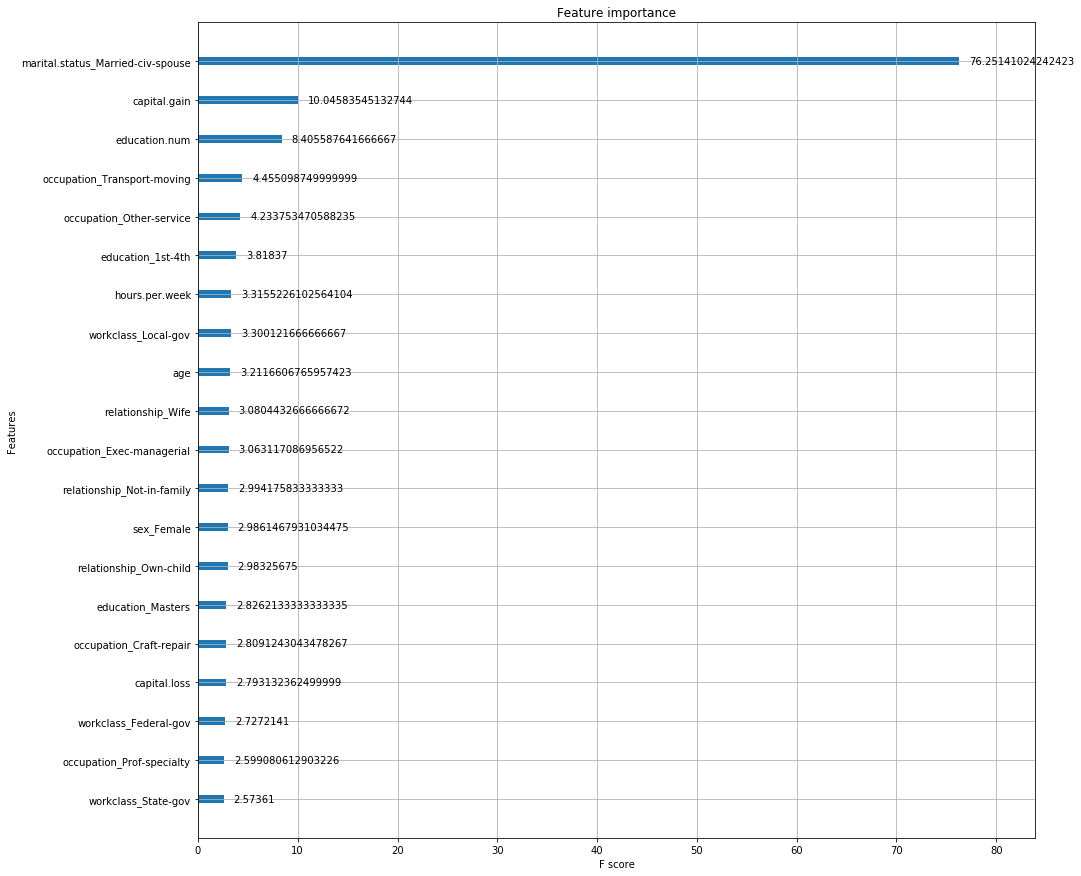

In [25]:
plt.figure(figsize=(15,15))
plot_importance(booster=estimator,max_num_features=20,ax=plt.gca(),importance_type='gain')
plt.show()

## Powinnismy dazyc do bardziej zrownowazonych modeli, zeby wiecje niz jedna cecha byla znaczaca w modelu

In [57]:
param_grid = {
    'max_depth': [3, 5, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150, 200, 400],
    'gamma': [0, 0.5, 1, 2],
    'colsample_bytree': [1, 0.8, 0.5],
    'subsample': [1, 0.8, 0.5],
    'min_child_weight': [1, 5, 10]
}

param_distribution = {
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.001, 0.1-0.001),
    'n_estimators': randint(50, 400),
    'gamma': uniform(0,2),
    'colsample_bytree': uniform(0.5, 0.5),
    'subsample': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 11)
}

In [64]:
grid_distr = RandomizedSearchCV(estimator,
                  param_distribution,
                  n_iter = 20,
                  cv=KFold(5,shuffle=True),
                               scoring= 'roc_auc')
grid_distr.fit(X_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f13996cd908>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1399627978>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1399627518>, 'gamma': <scipy.s...61b6d8>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1399553b70>},
          

In [65]:
grid_value = RandomizedSearchCV(estimator,
                  param_grid,
                  n_iter = 20,
                  cv=KFold(5,shuffle=True),
                               scoring = 'roc_auc')
grid_value.fit(X_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': [3, 5, 8, 10], 'learning_rate': [0.001, 0.01, 0.05, 0.1], 'n_estimators': [50, 100, 150, 200, 400], 'gamma': [0, 0.5, 1, 2], 'colsample_bytree': [1, 0.8, 0.5], 'subsample': [1, 0.8, 0.5], 'min_child_weight': [1, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [66]:
grid_distr.best_score_

0.91797021571077864

In [67]:
grid_value.best_score_

0.91704913773017838

In [68]:
grid_value.best_params_

{'colsample_bytree': 1,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 0.8}

In [69]:
grid_distr.grid_scores_

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.91283, std: 0.01144, params: {'colsample_bytree': 0.78586621242898591, 'gamma': 1.9761326106687838, 'learning_rate': 0.01336290738939297, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 345, 'subsample': 0.59847050698102544},
 mean: 0.91566, std: 0.00646, params: {'colsample_bytree': 0.57920181962287587, 'gamma': 1.7220488719250726, 'learning_rate': 0.059606235963592873, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 330, 'subsample': 0.88232763801487524},
 mean: 0.91640, std: 0.01237, params: {'colsample_bytree': 0.76917825948550078, 'gamma': 1.7731554332395849, 'learning_rate': 0.016095106293562363, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 216, 'subsample': 0.98466301980711346},
 mean: 0.91373, std: 0.00852, params: {'colsample_bytree': 0.50642432765969203, 'gamma': 0.96567361269303431, 'learning_rate': 0.049288096724146704, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 315, 'subsample': 0.61198709465189816},
 mean: 0.91620, std: 0.01126

In [70]:
grid_distr.grid_scores_[1][1]

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.9156587941148997

In [71]:
dist_scores = [res[1] for res in grid_distr.grid_scores_]
grid_scores = [res[1] for res in grid_value.grid_scores_]

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [72]:
max_scores = []
max_value = 0
for score in dist_scores:
    if score > max_value:
        max_scores.append(score)
        max_value = score
        continue
    else:
        max_scores.append(max_value)

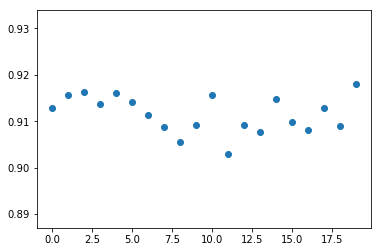

In [74]:
plt.scatter(range(len(dist_scores)), dist_scores)
plt.show()

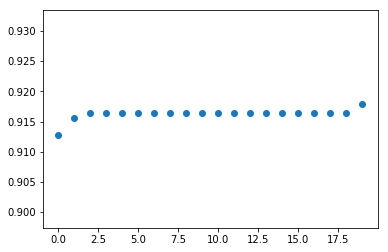

In [75]:
plt.scatter(range(len(max_scores)), max_scores)
plt.show()

In [76]:
max_scores_grid = []
max_value = 0
for score in grid_scores:
    if score > max_value:
        max_scores_grid.append(score)
        max_value = score
        continue
    else:
        max_scores_grid.append(max_value)

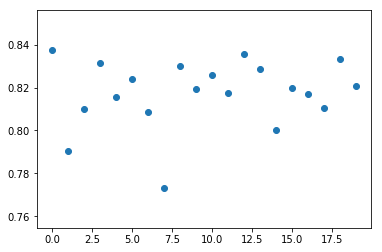

In [77]:
plt.scatter(range(len(value_scores)), value_scores)
plt.show()

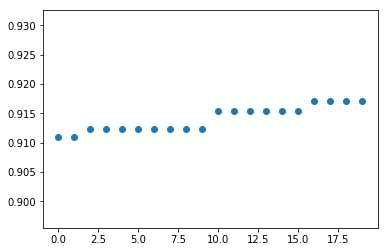

In [78]:
plt.scatter(range(len(max_scores_grid)), max_scores_grid)
plt.show()

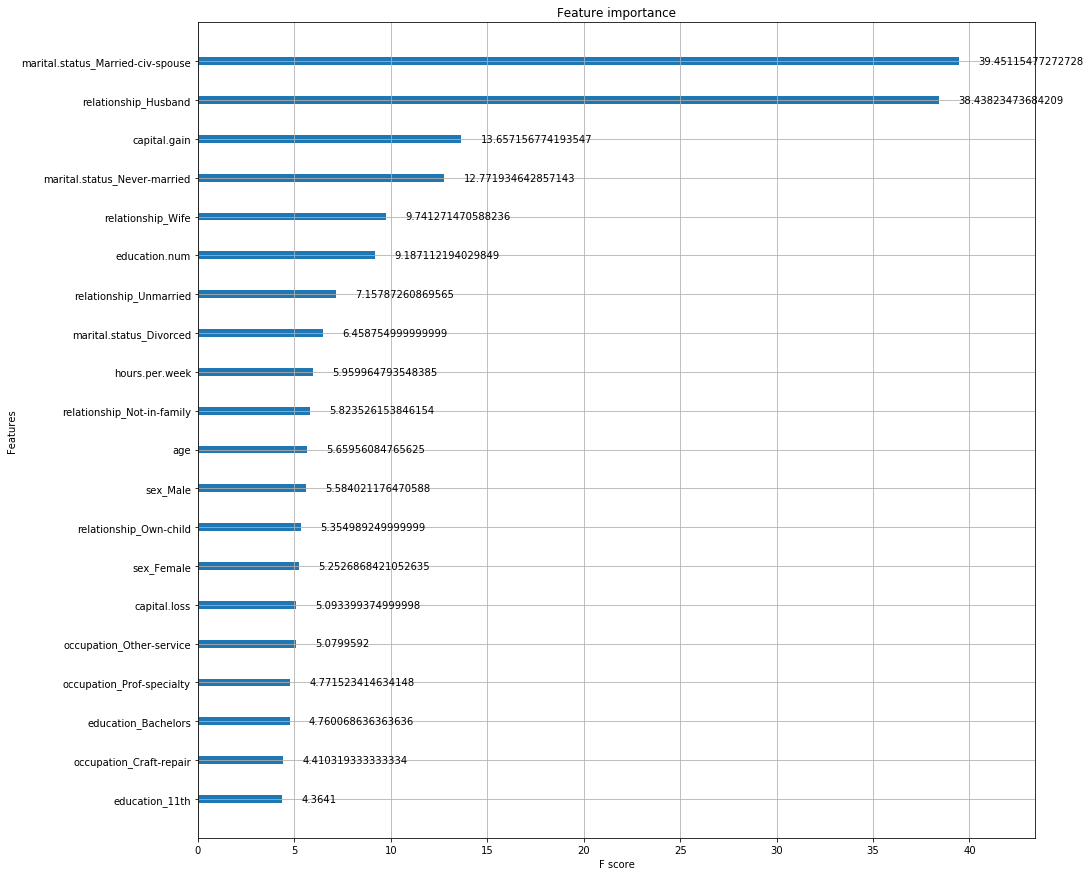

In [83]:
plt.figure(figsize=(15,15))
plot_importance(booster=grid_distr.best_estimator_,max_num_features=20,ax=plt.gca(),importance_type='gain')
plt.show()

In [92]:
(fpr_dist,tpr_dist,_) = roc_curve(y_true=y_test,y_score=grid_distr.predict_proba(X_test)[:,1])
(fpr_val,tpr_val,_) = roc_curve(y_true=y_test,y_score=grid_value.predict_proba(X_test)[:,1])

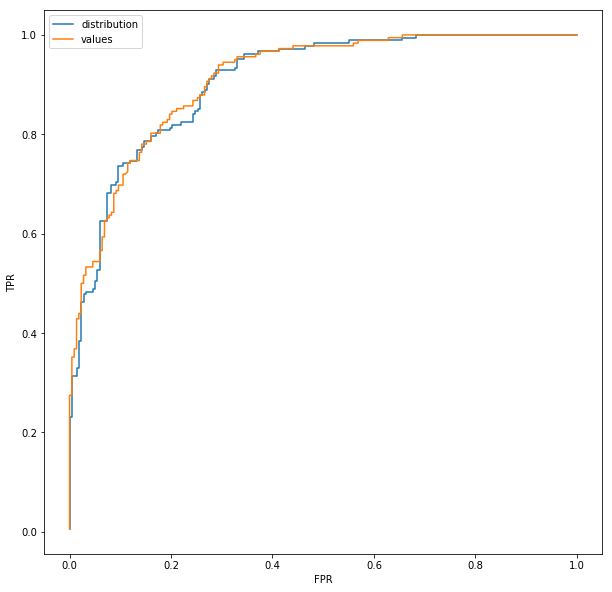

In [95]:
plt.figure(figsize=(10,10))
plt.plot(fpr_dist,tpr_dist,label='distribution')
plt.plot(fpr_val,tpr_val,label='values')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()